## Backprop: Softmax.

First, recall our `cross-entry loss function`.

$\displaystyle L = -ln(p_c)$

where $p_c$ is the predicted probablity for the correct class `c`. And our loss function is look like:

$\displaystyle L = -ln(p_i)$ if i equal to c, else the $L = 0$.

Define the $out_s$ as the output of the Softmax function. Then we can calculate the backword of the Softmax layer's phase $\displaystyle \frac {\partial L} {\partial out_s}$. Which we can know that $out_s$ is a vecotr of 10 probablities. And consider the loss L above.

$\displaystyle \frac {\partial L} {\partial out_s} = -\frac {1} {p_i}$ if i equal to c, else $\displaystyle \frac {\partial L} {\partial out_s} = 0$

Our initial gradient you saw referenced above:
```python
gradient = np.zeros(10)
gradient[label] = -1 / softmax[label]
```

First, let's calculate the gradient of $out_s(c)$ with the respect to its total parameters. Let $t_i$ be the total for the class $i$. 

$\displaystyle out_s(c) =  \frac {e ^ {t_c}} {S}$ where $S = \sum_i e ^ {t_i}$

Consider some class $k$ such that $k \neq c$, the derive of $\partial out_s(c)$ will be like:

$\displaystyle \frac {\partial {out_s(c)}} {\partial {t_k}} = \frac {\partial out_s(c)} {\partial S} ( \frac {\partial S} {\partial t_k}) = \frac {-e^{t_c} e^{t_i}} {S^2}$

The derivation for $c$ is:

$\displaystyle \frac {\partial {out_s(c)}} {\partial {t_c}} = \frac {\partial S e^{t_c} - e^{t_c} \frac {\partial S} {\partial t_c}} {S^2} = \frac {e^{t_c}(S - e^{t_c})} {S^2}$

In [109]:
import numpy as np
import mnist
import matplotlib.pyplot as plt
%matplotlib inline

In [544]:
class ConvLayer:
    def __init__(self, kernels, num_filters):
        self.kernels = kernels
        self.num_filters = num_filters
        # Our filters will be kernels * kernels * num_filters.
        self.filters = np.random.randn(num_filters, kernels, kernels) / 9
    
    def iterate_regions(self, image):
        """
        Generates all possible K x K image regions using vaild padding.
        - image is a 2d numpy array
        """
        height, width = image.shape
        for h in range(height-self.kernels+1):
            for w in range(width-self.kernels+1):
                yield image[h:h+self.kernels, w:w+self.kernels], h, w
    
    def forward(self, layer_input):
        """
        Performs a forward calculate of the conv layer using the given input.
        Returns a 3d numpy array with dimensions
        - imput is a 2D numpy array
        """
        # Only fit for the 2D input.
        height, width = layer_input.shape
        self.last_input = layer_input
        
        layer_output = np.zeros((height-self.kernels+1, width-self.kernels+1, self.num_filters))
        for image_region, h, w in self.iterate_regions(layer_input):
            layer_output[h,w] = np.sum(image_region * self.filters, axis=(1, 2))
        return layer_output

    def backprop(self, dLdout, learn_rate):
        dLdfilters = np.zeros(self.filters.shape)
        
        for image_region, h, w in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                dLdfilters[f] += dLdout[h, w, f] * image_region
        
        self.filters -= learn_rate * dLdfilters
        
        return None

In [545]:
class ReLu:
    def __init__(self):
        self.relu = lambda x: max(0, x)
    def forward(self, layer_input):
        height, width, filters = layer_input.shape
        for h in range(height):
            for w in range(width):
                for f in range(filters):
                    layer_input[h, w, f] = self.relu(layer_input[h, w, f])
        return layer_input
    
    def backprop(self, dLdout):
        return dLdout

In [546]:
class MaxPoolLayer:
    def __init__(self, size=2):
        """
        Max pool layer default size is 2.
        """
        self.size = size
    
    def iterate_regions(self, image):
        height, width, _ = image.shape
        mid_h = height // self.size
        mid_w = width // self.size
        for h in range(mid_h):
            for w in range(mid_w):
                image_region = image[h*self.size : self.size*(h+1),
                                     w*self.size : self.size*(w+1)]
                yield image_region, h, w
    
    def forward(self, layer_input):
        self.last_input = layer_input
        height, width, filters = layer_input.shape
        layer_output = np.zeros((height//self.size, width//self.size, filters))
        for image_region, h, w in self.iterate_regions(layer_input):
            layer_output[h, w] = np.max(image_region, axis=(0,1))
        return layer_output
    
    def backprop(self, dLdout):
        dLdinput = np.zeros(self.last_input.shape)
        
        for image_regions, h, w in self.iterate_regions(self.last_input):
            h, w, d = image_regions.shape
            target = np.max(image_regions, axis=(0,1))
            
            for i in range(h):
                for j in range(w):
                    for c in range(d):
                        if image_regions[i, j, c] == target[c]:
                            dLdinput[h*2 + i, w*2 + j, c] = dLdout[h, w, c]
        return dLdinput

In [547]:
class Softmax:
    def __init__(self, nodes):
        """
        Singletion for our Softmax layer.
        """
        self.biases = np.zeros(nodes)
    
    def cache_parameter(self, layer_input):
        """
        Calculate the mutpliy of the input and the weights.
        """
        self.last_input_shape = layer_input.shape
        if not hasattr(self, "weights"):
            w, h, d = layer_input.shape
            self.weights = np.random.randn(w * h * d, len(self.biases)) / (w * h * d)
        self.last_input = layer_input.flatten()
        self.last_totals = np.dot(self.last_input, self.weights) + self.biases
        return self.last_totals
    
    def forward(self, layer_input):
        """
        Softmax function return the possibility of the classifications
        """
        totals = self.cache_parameter(layer_input)
        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)
    
    def backprop(self, dLdout, learn_rate):
        for i, gradient in enumerate(dLdout):
            if gradient == 0:
                continue
            t_exp = np.exp(self.last_totals)
            S = np.sum(t_exp)
            doutdt = -t_exp[i] * t_exp / S ** 2
            doutdt[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)
            dtdw = self.last_input #
            dtdinputs = self.weights
            
            dLdt = gradient * doutdt
            dLdw = dtdw[np.newaxis].T @ dLdt[np.newaxis]
            dLdb = dLdt
            dLdinputs = dtdinputs @ dLdt
            self.weights -= learn_rate * dLdw
            self.biases -= learn_rate * dLdb
            
            return dLdinputs.reshape(self.last_input_shape)

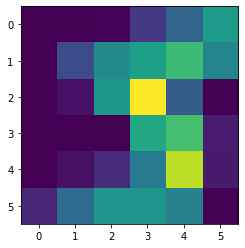

In [548]:
train_images = mnist.train_images()
train_label = mnist.train_labels()
conv = ConvLayer(3, 8)
conv_output = conv.forward(train_images[0])


max_pool = MaxPoolLayer(4)
max_pool_output = max_pool.forward(conv_output)
plt.imshow(max_pool_output[:,:,1])

In [549]:
soft = Softmax(10)
out = soft.forward(max_pool_output)

In [550]:
ans = np.zeros(len(out))
label = train_label[0]
ans[label] = - 1 / out[label]

In [557]:
class Mode(OrderedDict):
    def __init__(self, *kwargs):
        super().__init__(*kwargs)
        self.keys = list(self.keys())[::-1]
    
    def forward(self, image, label):
        out = (image / 255) - 0.5
        for key in self:
            out = self[key].forward(out)
        loss = -np.log(out[label]) # Cross-Entropy Loss
        acc = 1 if np.argmax(out) == label else 0
        
        return out, loss, acc
    
    def train(self, image, label, lr=0.005):
        out, loss, acc = self.forward(image, label)
        gradient = np.zeros(len(out))
        gradient[label] = -1 / out[label]
        for k in self.keys:
            if k == "softmax" or k == "convlayer":
                gradient = self[k].backprop(gradient, lr)
            else:
                gradient = self[k].backprop(gradient)
        
        return loss, acc

In [558]:
train_images = mnist.train_images()
train_label = mnist.train_labels()

In [561]:
m = Mode({
    "convlayer": ConvLayer(3, 8),
    "maxpool": MaxPoolLayer(),
    "softmax": Softmax(10),
})

In [562]:
print('Start trainning')

for epoch in range(100):
    print(f"---- Epoch {epoch + 1} ----")
    permutation = np.random.permutation(len(train_images))
    train_images = train_images[permutation]
    train_label = train_label[permutation]
    
    loss, num_correct = 0, 0
    for i, (image, label) in enumerate(zip(train_images[:1000], train_label[:1000])):
        if i % 100 == 99:
            print(
              '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
              (i + 1, loss / 100, num_correct)
            )
            loss = 0
            num_correct = 0
        l, acc = m.train(image, label)
        loss += l
        num_correct += acc

Start trainning
---- Epoch 1 ----
[Step 100] Past 100 steps: Average Loss 2.243 | Accuracy: 21%
[Step 200] Past 100 steps: Average Loss 2.170 | Accuracy: 32%
[Step 300] Past 100 steps: Average Loss 2.115 | Accuracy: 33%
[Step 400] Past 100 steps: Average Loss 2.035 | Accuracy: 47%
[Step 500] Past 100 steps: Average Loss 1.978 | Accuracy: 54%
[Step 600] Past 100 steps: Average Loss 1.914 | Accuracy: 57%
[Step 700] Past 100 steps: Average Loss 1.835 | Accuracy: 61%
[Step 800] Past 100 steps: Average Loss 1.806 | Accuracy: 56%
[Step 900] Past 100 steps: Average Loss 1.652 | Accuracy: 67%
[Step 1000] Past 100 steps: Average Loss 1.664 | Accuracy: 65%
---- Epoch 2 ----
[Step 100] Past 100 steps: Average Loss 1.646 | Accuracy: 66%
[Step 200] Past 100 steps: Average Loss 1.594 | Accuracy: 67%
[Step 300] Past 100 steps: Average Loss 1.485 | Accuracy: 73%
[Step 400] Past 100 steps: Average Loss 1.466 | Accuracy: 79%
[Step 500] Past 100 steps: Average Loss 1.492 | Accuracy: 72%
[Step 600] Past 1

In [563]:
m.forward(train_images[1], train_label[1])

(array([1.47913538e-04, 5.93020435e-02, 2.69612095e-03, 1.48460038e-01,
        9.34899903e-02, 2.38336589e-02, 1.42922654e-03, 1.04790550e-01,
        2.00423073e-02, 5.45808151e-01]), 0.6054877367989941, 1)

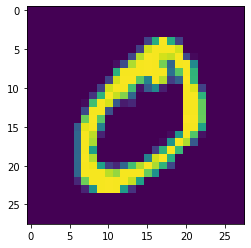

In [408]:
plt.imshow(train_images[1])